In [1]:
import h5py
import hdbscan
import matplotlib.pyplot as plt
import numpy as np
import umap

from neuropacks import ECOG
from pyuoi.decomposition import UoI_NMF 
from sklearn.decomposition import NMF
from sklearn.preprocessing import normalize 

from utils import *
%matplotlib inline

/home/psachdeva/anaconda3/envs/neuro/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/home/psachdeva/anaconda3/envs/neuro/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
data_path = '/storage/data/ecog/r32_b7.mat'
grid_path = '/storage/data/ecog/grdid.mat'
ecog = ECOG(
    data_path=data_path,
    grid_path=grid_path
)

In [3]:
Y = ecog.get_response_matrix(
    bounds=(40, 60),
    band='HG'
)

In [4]:
# kill the dead indices
dead_indices = [19, 21, 0]

In [5]:
Y = Y + np.abs(np.min(Y, axis=0, keepdims=True))
Y[:, dead_indices] = 0
# Y[Y < 0] = 0

In [6]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=12)

# Multiple Ranks

In [7]:
uoi = UoI_NMF(
    n_boots=30,
    ranks=[27, 28, 29, 30, 31, 32, 33],
    nmf_max_iter=1000)

In [8]:
uoi.cluster = clusterer

In [9]:
H, clusters = uoi.fit(Y)

In [14]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(H)

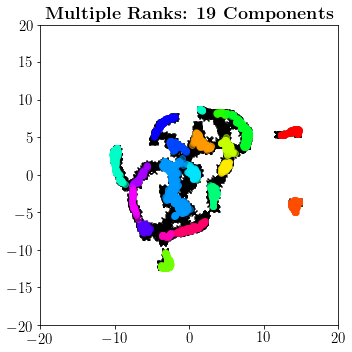

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

cluster_ids = np.unique(clusters)
n_clusters = cluster_ids.size - 1

for idx, c_id in enumerate(cluster_ids):
    group = np.argwhere(clusters == c_id).ravel()
    bases = embedding[group]
    
    if c_id == -1:
        ax.scatter(bases[:, 0], bases[:, 1], marker='x', color='k')
    else:
        ax.scatter(bases[:, 0], bases[:, 1], alpha=0.5,
                   color=plt.get_cmap('hsv')(int(255 * c_id / n_clusters)))

ax.tick_params(labelsize=15)
ax.set_ylim([-20, 20])
ax.set_xlim(ax.get_ylim())
ax.set_title(r'\textbf{Multiple Ranks: 19 Components}', fontsize=18)
plt.tight_layout()
plt.savefig('nmf_embedding_multiple_ranks.pdf')

In [85]:
uoi = UoI_NMF(
    n_boots=30,
    ranks=[30],
    nmf_max_iter=1000)

In [86]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=5)
uoi.cluster = clusterer

In [87]:
H, clusters = uoi.fit(Y)

In [90]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(H)

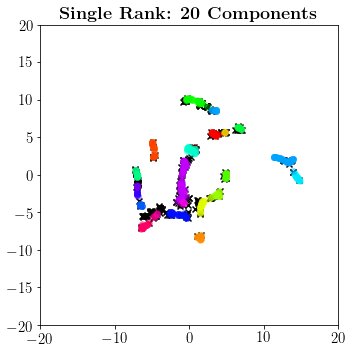

In [91]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

cluster_ids = np.unique(clusters)
n_clusters = cluster_ids.size - 1

for idx, c_id in enumerate(cluster_ids):
    group = np.argwhere(clusters == c_id).ravel()
    bases = embedding[group]
    
    if c_id == -1:
        ax.scatter(bases[:, 0], bases[:, 1], marker='x', color='k')
    else:
        ax.scatter(bases[:, 0], bases[:, 1], alpha=0.30,
                   color=plt.get_cmap('hsv')(int(255 * c_id / n_clusters)))

ax.tick_params(labelsize=15)
ax.set_ylim([-20, 20])
ax.set_xlim(ax.get_ylim())
ax.set_title(r'\textbf{Single Rank: 20 Components}', fontsize=18)
plt.tight_layout()
plt.savefig('nmf_embedding2.pdf')